In [1]:
%load_ext autoreload
%autoreload 2

# Doing Data Viz in Python

Ned Letcher

[nedned.net](http://nedned.net)

### Goal of data analysis

_Derive information and insights in order to improve our understanding and inform decision making_

### Relevance of data visualisation
1. Analysise and explore
2. Communicate findings

This talk is about showing you Python tools for how to achieve these goals, and some tips for how to use them 


## Data Viz for exploratory data analysis

### Your Task

Use the Melbourne City Council [Pedestrian Counting System dataset](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-2009-to-Present-counts-/b2ak-trbp) for answer the following question:

_How has the COVID-19 pandemic impacted foot traffic in the Melbourne CBD?_

### Data prep

In [2]:
from pathlib import Path

DATA_PATH = Path("data/Pedestrian_Counting_System___2009_to_Present__counts_per_hour_.csv")

In [3]:
import pandas as pd

df = pd.read_csv(DATA_PATH)
df.head()

ID               Date_Time  Year     Month  Mdate     Day  Time  \
0  2887628  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
1  2887629  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
2  2887630  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
3  2887631  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
4  2887632  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   

   Sensor_ID                   Sensor_Name  Hourly_Counts  
0         34          Flinders St-Spark La            300  
1         39                  Alfred Place            604  
2         37               Lygon St (East)            216  
3         40  Lonsdale St-Spring St (West)            627  
4         36               Queen St (West)            774

In [4]:
def load_and_clean_pedestrian_data(path):
    df = pd.read_csv(path)
    df["datetime"] = pd.to_datetime(
        {
            "day": df["Mdate"],
            "year": df["Year"],
            "hour": df["Time"],
            "month": pd.to_datetime(df["Month"], format='%B').dt.month
        }
    )
    return df

df = load_and_clean_pedestrian_data(DATA_PATH)
df.head()

ID               Date_Time  Year     Month  Mdate     Day  Time  \
0  2887628  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
1  2887629  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
2  2887630  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
3  2887631  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
4  2887632  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   

   Sensor_ID                   Sensor_Name  Hourly_Counts            datetime  
0         34          Flinders St-Spark La            300 2019-11-01 17:00:00  
1         39                  Alfred Place            604 2019-11-01 17:00:00  
2         37               Lygon St (East)            216 2019-11-01 17:00:00  
3         40  Lonsdale St-Spring St (West)            627 2019-11-01 17:00:00  
4         36               Queen St (West)            774 2019-11-01 17:00:00

### Let's have a look at what's in the data

_Q: How many years does the dataset cover?_

In [5]:
YEARS = sorted(df["Year"].unique())
YEARS

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

_Q: How many sensors are in the datset?_

In [6]:
SENSORS = df["Sensor_Name"].unique()
SENSORS.shape

(69,)

_Q: How many people are recorded each year?_

In [7]:
year_counts = df.groupby("Year")["Hourly_Counts"].sum()
year_counts

Year
2009     62650110
2010     93459437
2011     90571965
2012    102215521
2013    117389820
2014    169500386
2015    209099687
2016    228757880
2017    216586414
2018    261909318
2019    266411675
2020     65584490
Name: Hourly_Counts, dtype: int64

Just eyeballing the data isn't going to cut it. Let's visualise with Pandas' plotting API.

This uses the Matplotlib library, so first set it up and configure. The first line below tells Jupyter to automatically render Matplotlib plots in the cell's output. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

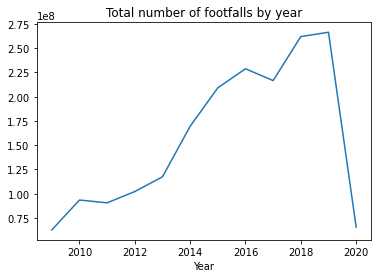

In [9]:
year_counts.plot(title="Total number of footfalls by year")

_Tip: always title your plots._

Problem is that the number of sensors increases.

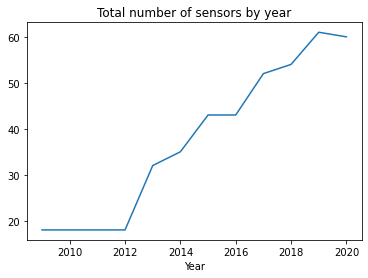

In [10]:
num_sensors = df.groupby("Year")["Sensor_Name"].nunique()
num_sensors.plot(title="Total number of sensors by year")

Let's normalise by number of sensors.

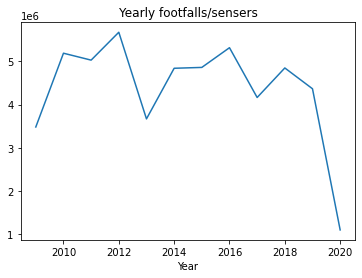

In [11]:
year_counts_df  = df.groupby("Year").agg({"Hourly_Counts":sum, "Sensor_Name": "nunique"})
year_counts_df["count_per_sensor"] = year_counts_df["Hourly_Counts"] / year_counts_df["Sensor_Name"]
year_counts_df["count_per_sensor"].plot(title="Yearly footfalls/sensers");

Not clear how helpful this is... maybe newer sensors are more likely to be in less travelled areas and our footfalls shouldn't be spread across them to the same weight as more trafficked sensors.


In [12]:
# Build up a DataFrame of sensor names with their average yearly counts and first year of existence:

# get average yearly counts
res_df = pd.DataFrame(
    df.groupby("Sensor_Name").apply(
        lambda df:df.groupby("Year")["Hourly_Counts"].sum().mean()
    ), 
    columns=["average_yearly_counts"]
)

# get first year of existence for each sensor
sorted_df = df.sort_values(by="Year")
res_df["first_year"] = [
    sorted_df[sorted_df["Sensor_Name"] == sensor].iloc[0]["Year"]
    for sensor in res_df.index
]

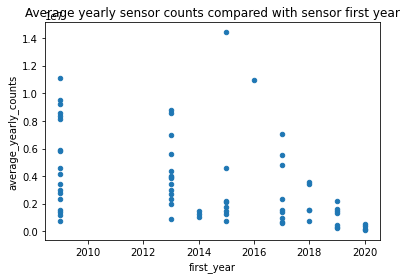

In [13]:
# can also use df.plot.scatter()
res_df.plot(kind="scatter", x="first_year", y="average_yearly_counts", title="Average yearly sensor counts compared with sensor first year");

### Pandas' plotting API
* Built on Matplotlib (has its own API, which Pandas hides)
* Really useful for quick exploratory visualisation for `DataFrame` and `Series`

#### Limitations
1. Doesn't look very pretty out of the box
2. Pandas plotting API is limited
3. Static image: can’t zoom or toggle visibility of data


### What are your options?

#### 1. Improve Aesthetics using Matplotlib Themes

In [14]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [15]:
plt.style.use('seaborn')

#### 2. Work with Matplotlib's API

* Pandas's `plot()` produces Matplotlib objects Can break out into full Matplotlib API
* Matplotlib API is very powerful, but API can be hard to learn

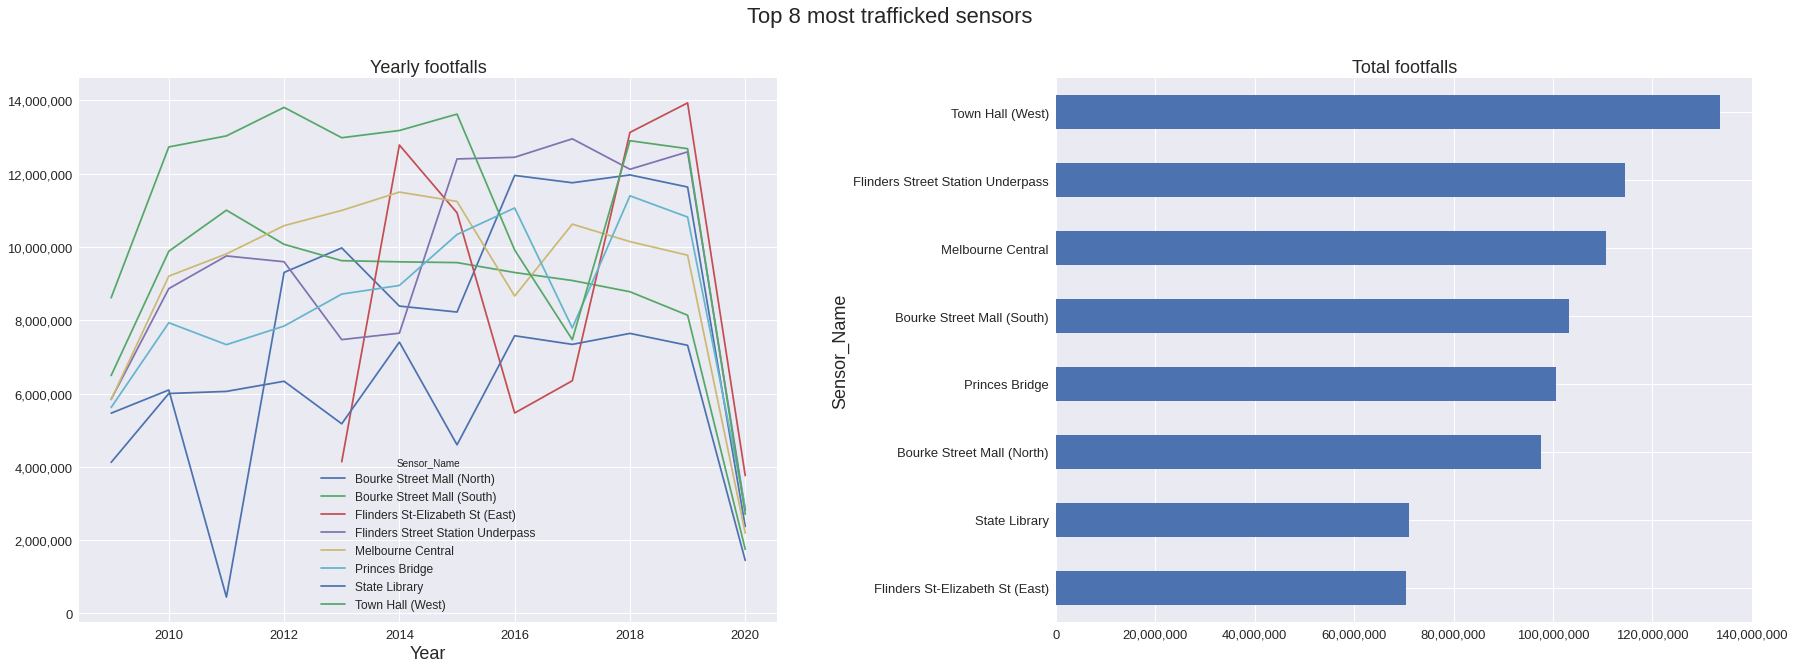

In [16]:
from matplotlib import ticker 

def make_top_sensor_plot(df, num_sensors=8):
    # make and configure our split figure
    plt.rcParams.update(
        {"figure.titlesize": 22, "axes.titlesize": 18, "axes.labelsize": 18, 
         "legend.fontsize": 12, "xtick.labelsize":13, "ytick.labelsize":13}
    )
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=.4)

    fig.suptitle(f"Top {num_sensors} most trafficked sensors")
    ax1.set_title("Yearly footfalls")
    ax2.set_title("Total footfalls")
    
    # make numeric axes comma separated integers
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # filter the data to the top 8 busiest sensors
    sensor_counts = df.groupby("Sensor_Name")["Hourly_Counts"].sum().nlargest(8)
    top_df = df[df["Sensor_Name"].isin(set(sensor_counts.index))]

    # plot their total counts by year in axis 1
    top_df.groupby("Sensor_Name").apply(
        lambda df:df.groupby("Year")["Hourly_Counts"].sum()
    ).unstack().transpose().plot(ax=ax1, figsize=(30, 10))

    # plot their aggregate counts in axis 2
    sensor_counts.sort_values(ascending=True).plot.barh(ax=ax2);


make_top_sensor_plot(df)

#### 3. Use Another Python Data 

![Python Data Visualisation Landscape](img/viz_landscape.png)

[Jake VanderPlas The Python Visualization Landscape PyCon 2017](https://www.youtube.com/watch?v=FytuB8nFHPQ)

### How to choose?

* What is the intended use case?
 * data exploration
 * data communication
 * decision support
* Does your data have domain-specific needs?
 * spatial data
 * network data
 * big data
* Does it need to be interactive?
* Does it need to be made available to end consumers?


## Some Good General-purpose Libraries for Data Analysis

## Seaborn

Seaborn is a library built on top of Matplotlib. 

Provides:
* API designed for statistical visualisation
* Recipes for producing specialised plots
* Improved visual appearance

Like Matplotlib, only produces static images

**Links**
* [Seaborn Overview](https://seaborn.pydata.org/introduction.html)
* [Gallery](https://seaborn.pydata.org/examples/index.html)


/home/ned/.pyenv/versions/3.8.3/envs/pydata-viz/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations

/home/ned/.pyenv/versions/3.8.3/envs/pydata-viz/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



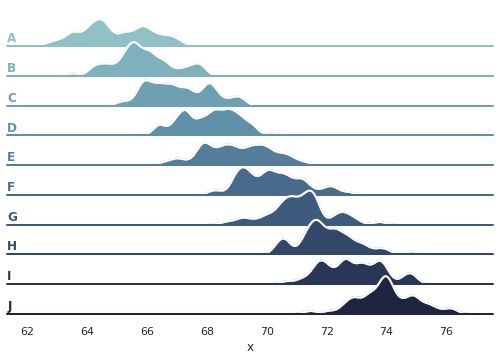

In [44]:
# Ridgeplot
# https://seaborn.pydata.org/examples/kde_ridgeplot.html
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True);

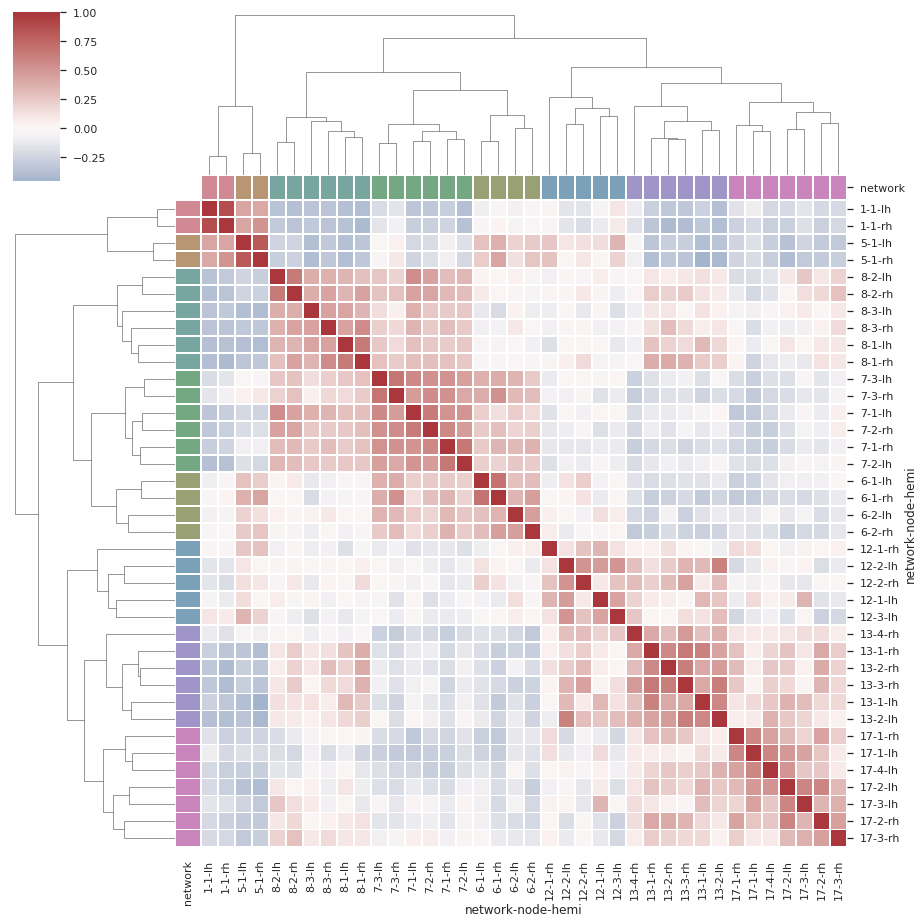

In [43]:
# clustermap 
# https://seaborn.pydata.org/examples/structured_heatmap.html

import pandas as pd
import seaborn as sns
sns.set()

# Load the brain networks example dataset
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Select a subset of the networks
used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# Draw the full plot
sns.clustermap(df.corr(), center=0, cmap="vlag",
               row_colors=network_colors, col_colors=network_colors,
               linewidths=.75, figsize=(13, 13));

## Bokeh

TODO

**Links**
* [Gallery](https://docs.bokeh.org/en/latest/docs/gallery.html#gallery)
* [Jupyer Notebook/Lab setup](https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html)



## Altair

TODO

**Links**
* [Gallery](https://altair-viz.github.io/gallery/index.html)
* [Jupyter Notebook/Lab setup](https://altair-viz.github.io/user_guide/display_frontends.html#displaying-in-jupyterlab)

### Altair Demos

In [33]:
# Layered Histogram
# https://altair-viz.github.io/gallery/layered_histogram.html

import pandas as pd
import altair as alt
import numpy as np
np.random.seed(42)

# Generating Data
source = pd.DataFrame({
    'Trial A': np.random.normal(0, 0.8, 1000),
    'Trial B': np.random.normal(-2, 1, 1000),
    'Trial C': np.random.normal(3, 2, 1000)
})

alt.Chart(source).transform_fold(
    ['Trial A', 'Trial B', 'Trial C'],
    as_=['Experiment', 'Measurement']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Experiment:N')
)

alt.Chart(...)

In [45]:
# Chloropleth
# https://altair-viz.github.io/gallery/choropleth.html

import altair as alt
from vega_datasets import data

counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

alt.Chart(...)

In [46]:
# Selection Histogram
# https://altair-viz.github.io/gallery/selection_histogram.html

import altair as alt
from vega_datasets import data

source = data.cars()

brush = alt.selection(type='interval')

points = alt.Chart(source).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='Origin:N',
    color='Origin:N',
    x='count(Origin):Q'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

## Plotly

TODO 


**Links**
* [Jupyer Notebook/Lab setup](https://plotly.com/python/getting-started/)

In [31]:
# TODO Some examples using Plotly Express

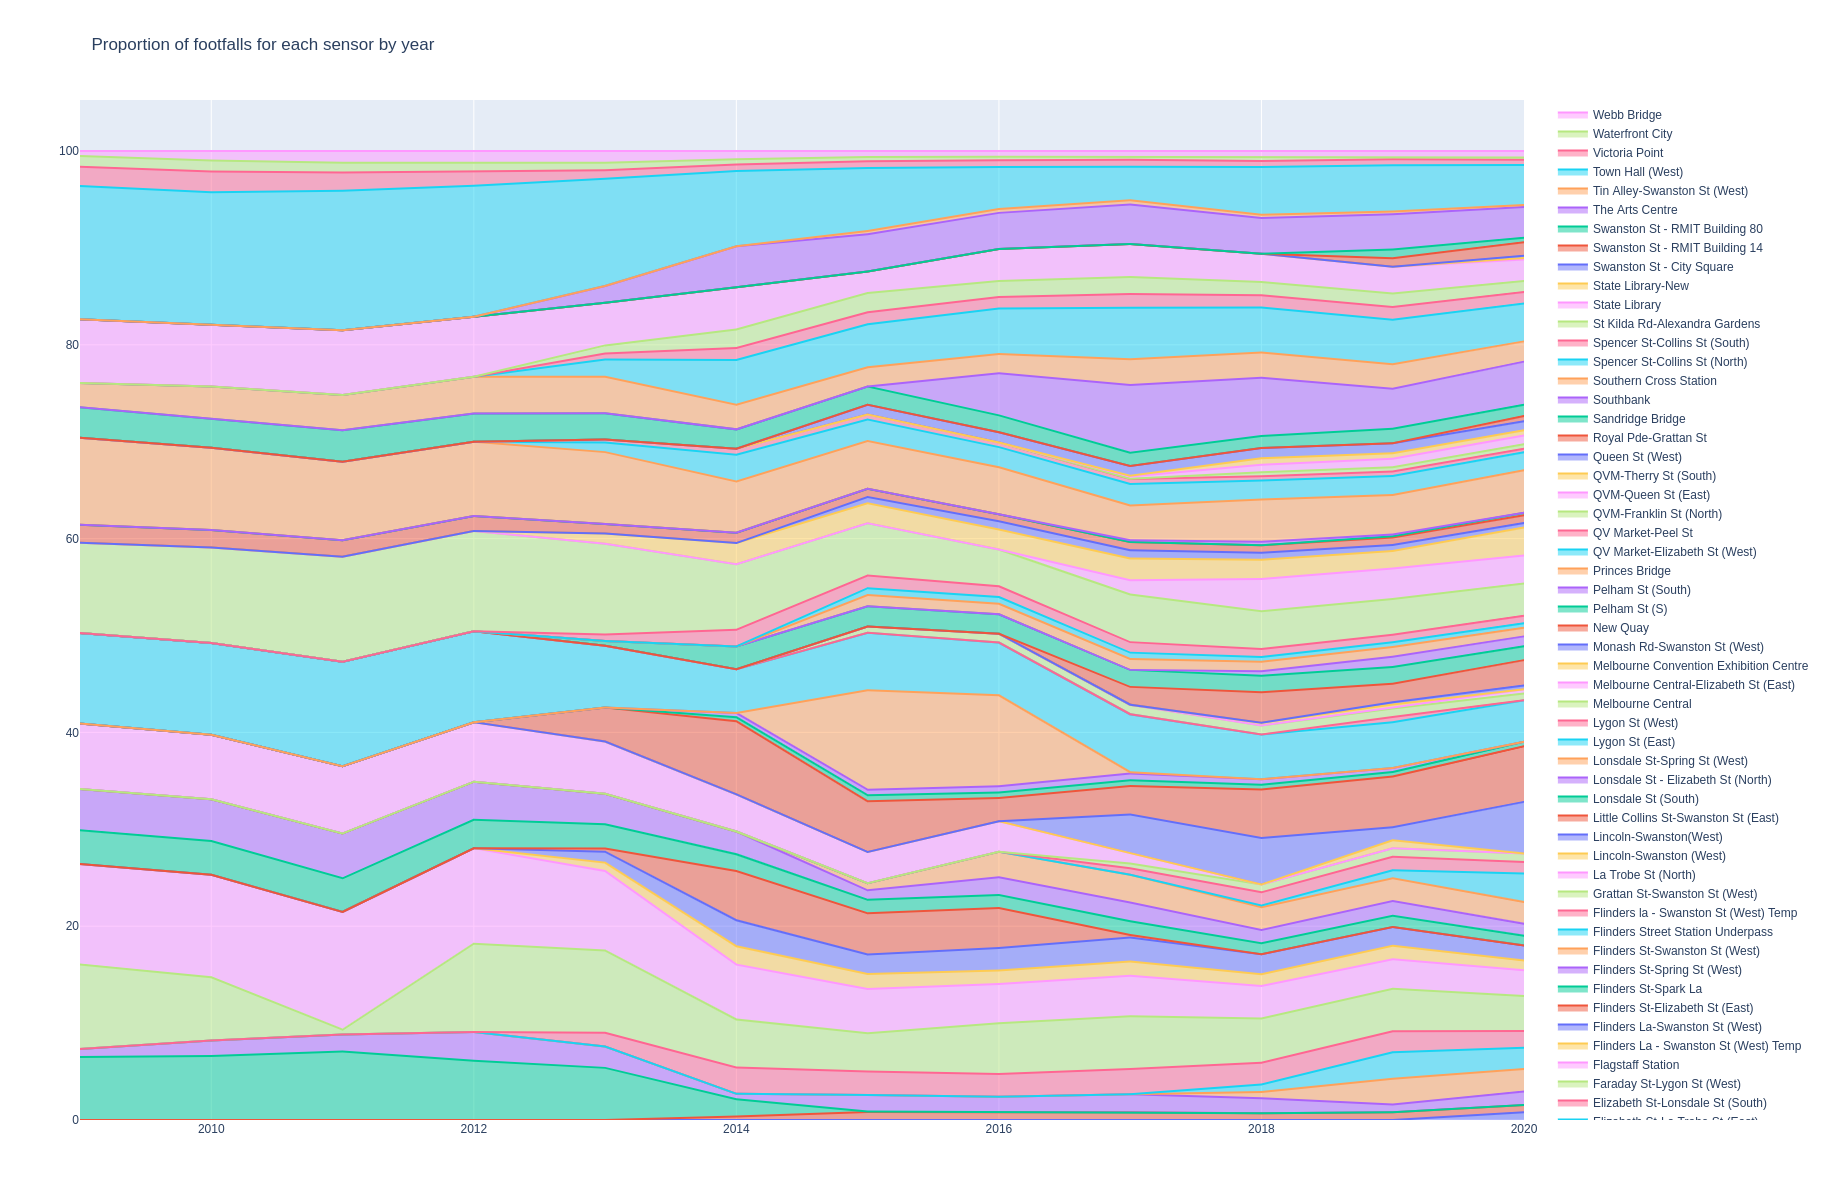

In [18]:
import plotly.graph_objects as go

def make_stacked_sensor_plot(df, years=None, sensors=None, normalised=True):
    if years is not None:
        df = df[df["Year"].isin(years)]
    if sensors is not None:
        df = df[df["Sensor_Name"].isin(sensors)]
    sensor_years_s = df.groupby(["Sensor_Name", "Year"])["Hourly_Counts"].sum()
    sensor_dfs = [(sensor, dfx.reset_index("Sensor_Name")) for sensor, dfx in sensor_years_s.groupby(level=0)]

    fig = go.Figure()
    for sensor, df in sensor_dfs:   
        fig.add_trace(go.Scatter(
            x=df.index, y=df["Hourly_Counts"],
            #mode='lines',
            name=sensor,
            stackgroup='one',
            groupnorm='percent' if normalised else "",
        ))

    fig.update_layout(width=1500, height=1200, title="Proportion of footfalls for each sensor by year")
    return fig

make_stacked_sensor_plot(df)

## Making our Plots Interactive

TODO:

* make this interactive with ipywidgets (and Figure Widget)
* introduce voila
* then copy into separate notebook and deploy with ngrok for them to demo
* will come back to this later for dashboards

## Visualising Spatial Information

Python Libraries for visualisang Spatial information

* [GeoPandas](https://geopandas.org)
* [Folium](https://python-visualization.github.io/folium/)
* [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet)
* [GeoViews](https://geoviews.org)
* [Cartopy](https://scitools.org.uk/cartopy/docs/latest)
* [QGIS](https://qgis.org)


### Demo: Pedestrian Footfall Spatial Visualisation 

TODO: geocode and visualise the footfall data in a basic way

### Demo: Datashader

[Datashader](https://datashader.org) is a graphics pipeline system for creating meaningful representations of large datasets quickly and flexibly.

[US Census Data Visualisation](https://examples.pyviz.org/census/census.html)

## Making Interactive Dashboards

Contexts:
* A dashboard for decision support (eg business intelligence)
* Custom reports
* Making an interactive notebook available for other people to explore
* Custom tool for use in data project 

Libraries:
* [Voila](https://github.com/voila-dashboards/voila)
* [Panel](https://panel.holoviz.org)
* [Plotly Dash](https://plotly.com/dash)
* [Streamlit](https://www.streamlit.io/)

Useful Talk Surveying these: _Analytic Web Apps in Python_
* [Video](https://www.youtube.com/watch?v=K7eDJT7djro)
* [Slides](http://ned.nedned.net/data_superpower.pdf)